In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
df = pd.read_csv("../data/processed/advanced_cleaned_data.csv")

df.head()


,year,month,country,region,avg_temp_c,precipitation_mm,air_quality_index,uv_index,malaria_cases,dengue_cases,population_density,healthcare_budget,season,malaria_lag_1,malaria_lag_3,outbreak_flag
0,2000,1,Saint Kitts and Nevis,Central,14.742725,0.000000,16.447042,9.846464,22,1,441,4936,Winter,101.0,53.0,0
1,2000,1,Lesotho,Central,12.411940,224.323243,114.397538,9.208128,60,88,296,1288,Winter,22.0,17.0,0
2,2000,1,Isle of Man,Central,18.674863,10.868287,0.000000,11.514195,0,100,397,4671,Winter,60.0,101.0,0
3,2000,1,Guyana,Central,18.845423,2.401021,47.879011,8.686426,89,106,458,2650,Winter,0.0,22.0,0
4,2000,1,Bahamas,Central,19.529292,98.441882,103.878215,9.814734,21,41,238,961,Winter,89.0,60.0,0


In [3]:
y = df["malaria_cases"]


In [4]:
X = df[
    [
        "avg_temp_c",
        "precipitation_mm",
        "air_quality_index",
        "uv_index",
        "population_density",
        "healthcare_budget",
        "month",
        "malaria_lag_1",
        "malaria_lag_3"
    ]
]

y = df["malaria_cases"]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [6]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R2:", r2_lr)


Linear Regression RMSE: 41.676326493785965
Linear Regression R2: 0.15922337927172736


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators": [50, 80],
    "max_depth": [5, 10],
    "min_samples_split": [5, 10]
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=2,      # 🔥 reduced
    cv=2,          # 🔥 reduced
    scoring="neg_root_mean_squared_error",
    random_state=42
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print(random_search.best_params_)


{'n_estimators': 80, 'min_samples_split': 5, 'max_depth': 5}


In [9]:
y_class = df["outbreak_flag"]


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.99      0.92      5940
           1       0.34      0.03      0.05       969

    accuracy                           0.86      6909
   macro avg       0.60      0.51      0.49      6909
weighted avg       0.79      0.86      0.80      6909



In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [12]:
best_model.fit(X_train, y_train)

y_pred_rf = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Tuned RF RMSE:", rmse_rf)
print("Tuned RF R2:", r2_rf)


Tuned RF RMSE: 41.695046516793205
Tuned RF R2: 0.15846789557714236


In [13]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Tuned Random Forest"],
    "RMSE": [rmse_lr, rmse_rf],
    "R2 Score": [r2_lr, r2_rf]
})

results


,Model,RMSE,R2 Score
0,Linear Regression,41.676326,0.159223
1,Tuned Random Forest,41.695047,0.158468


In [14]:
importance = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance


precipitation_mm      0.483679
avg_temp_c            0.385319
healthcare_budget     0.118109
air_quality_index     0.008775
malaria_lag_3         0.001056
uv_index              0.001019
malaria_lag_1         0.000774
population_density    0.000719
month                 0.000551
dtype: float64

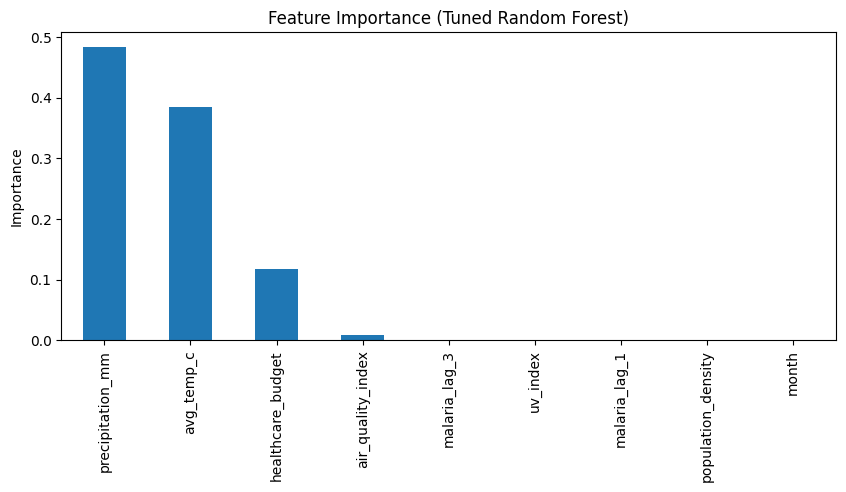

In [15]:
importance.plot(kind="bar", figsize=(10,4))
plt.title("Feature Importance (Tuned Random Forest)")
plt.ylabel("Importance")

plt.savefig("../visuals/feature_importance_tuned_rf.png", bbox_inches="tight")
plt.show()


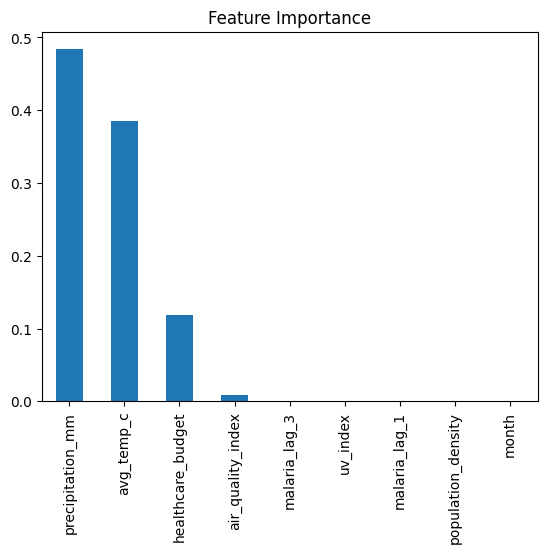

In [16]:
importance.plot(kind="bar")
plt.title("Feature Importance")
plt.savefig("../visuals/feature_importance.png", bbox_inches="tight")
plt.show()


In [17]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

joblib.dump(best_model, "../models/tuned_rf_model.pkl")


['../models/tuned_rf_model.pkl']